In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

import mglearn
import spacy
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, recall_score, precision_recall_curve, roc_auc_score

In [53]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

max_criticas = 10000
corpus = D.data[:max_criticas]
y = D.target[:max_criticas]
yb = np.array([1 if val>5 else 0 for val in y])

print("Tamanho corpus: {} documentos".format(len(corpus)))
print("Classes: {}".format(np.unique(y)))
print("Classes: {}".format(np.unique(yb)))
print("Distribuição de criticas por classe: ", np.bincount(y))
print("Distribuição de criticas por classe: ", np.bincount(yb))

Tamanho corpus: 10000 documentos
Classes: [ 1  2  3  4  7  8  9 10]
Classes: [0 1]
Distribuição de criticas por classe:  [   0 2074  924  921 1091    0    0 1007 1189  911 1883]
Distribuição de criticas por classe:  [5010 4990]


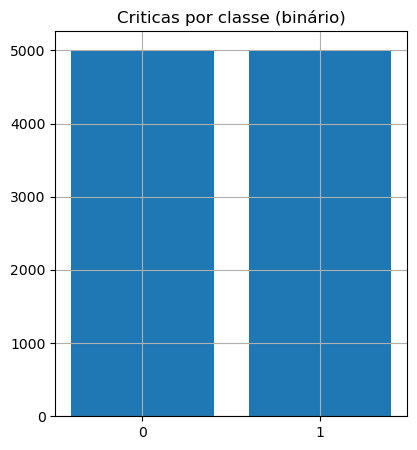

In [81]:
labels, counts = np.unique(yb, return_counts=True)

plt.figure(figsize=(10,5))
plt.subplot(121)
labels, counts = np.unique(yb, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Criticas por classe (binário)")
plt.grid(True)

In [55]:
# Limpeza de dados
corpus = [critica.replace("<br />", " ") for critica in corpus]
corpus = [" ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) for critica in corpus]
corpus = [" ".join(lemma.lemmatize(palavra) for palavra in critica.split()) for critica in corpus]

# Vetorização 
tf = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,3)).fit(corpus)
corpus_p = tf.transform(corpus)


In [58]:
# Separação em treino e teste
corpus_trainval, corpus_test, y_trainval, y_test = train_test_split(corpus_p, yb, test_size=1/3, shuffle=True, stratify=y)
corpus_train, corpus_validation, y_train, y_validation = train_test_split(corpus_trainval, y_trainval, test_size=1/2, shuffle=True, stratify=y_trainval)


print(corpus_train.shape, corpus_validation.shape, corpus_test.shape)

(3333, 92879) (3333, 92879) (3334, 92879)


In [60]:
print("Treino", len(y_train))
print("Distribuição (Treino)", np.bincount(y_train))

print("\nValidação", len(y_validation))
print("Distribuição (Validação)", np.bincount(y_validation))

print("\nTeste", len(y_test))
print("Distribuição (Teste)", np.bincount(y_test))

Treino 3333
Distribuição (Treino) [1670 1663]

Validação 3333
Distribuição (Validação) [1670 1663]

Teste 3334
Distribuição (Teste) [1670 1664]


## Discriminante Logístico

In [61]:
pipe = make_pipeline(LogisticRegression(max_iter=10000))
param_grid = {'logisticregression__C': [0.1, 1, 10, 100], 
            'logisticregression__solver': ['liblinear'], 
            'logisticregression__multi_class': ['auto', 'ovr'], 
            'logisticregression__penalty': ['l1', 'l2']}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validation, y_validation)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.501 total time=   0.0s
[CV 3/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.501 total time=   0.0s
[CV 1/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.833 total time=   0.0s
[CV 2/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.813 total time=   0.0s
[CV 3/3] END logisticregression__C=0.1,

In [62]:
#lr = LogisticRegression(C=10, penalty='l2', multi_class='auto', solver='liblinear')
lr = LogisticRegression(C=100, penalty='l2', multi_class='auto', solver='liblinear')
lr.fit(corpus_trainval, y_trainval)

#Treino
y_train_e = lr.predict(corpus_trainval)
#Teste
y_test_e = lr.predict(corpus_test)


(3333, 92879) (3333, 92879) (3334, 92879)


1.0
0.942475025909719


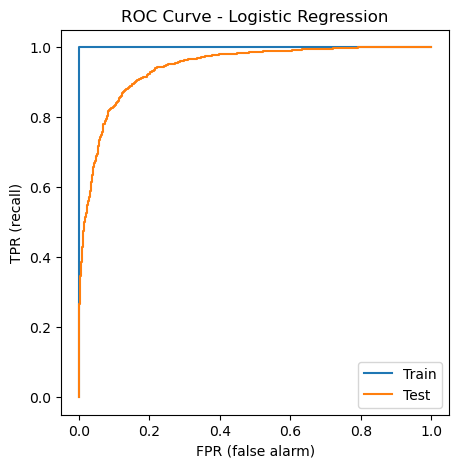

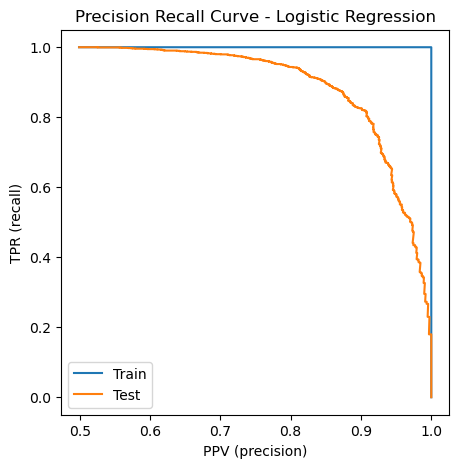

In [65]:
lr_auc_train = roc_auc_score(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
print(lr_auc_train)

lr_auc_test = roc_auc_score(y_test, lr.predict_proba(corpus_test)[:, 1])
print(lr_auc_test)

lr_fpr_roc_train, lr_tpr_roc_train, lr_thresholds_roc_train = roc_curve(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
lr_fpr_roc_test, lr_tpr_roc_test, lr_thresholds_roc_test = roc_curve(y_test, lr.predict_proba(corpus_test)[:, 1])
plt.figure(figsize=(5,5))
plt.title("ROC Curve - Logistic Regression")
plt.plot(lr_fpr_roc_train, lr_tpr_roc_train, label="Train")
plt.plot(lr_fpr_roc_test, lr_tpr_roc_test, label="Test")
plt.xlabel("FPR (false alarm)")
plt.ylabel("TPR (recall)")
plt.legend()


lr_curve_precision_train, lr_curve_recall_train, lr_thresholds_train = precision_recall_curve(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
lr_curve_precision_test, lr_curve_recall_test, lr_thresholds_test = precision_recall_curve(y_test, lr.predict_proba(corpus_test)[:, 1])
plt.figure(figsize=(5,5))
plt.title("Precision Recall Curve - Logistic Regression")
plt.plot(lr_curve_precision_train, lr_curve_recall_train, label="Train")
plt.plot(lr_curve_precision_test, lr_curve_recall_test, label="Test")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()



### Resultados Treino

Amostras:  [3340 3326]
Número de erros (treino): 0
Matriz de Confusão:


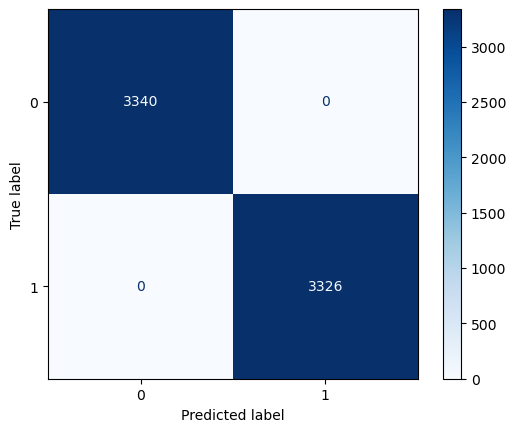

In [69]:
matriz_confusao = confusion_matrix(y_trainval, y_train_e)


print("Amostras: ", np.bincount(y_train_e))
print("Número de erros (treino): {}".format(np.sum(y_trainval != y_train_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')

tn, fp, fn, tp = matriz_confusao.ravel()
lr_fpr_train = fp / (fp + tn)
lr_tpr_train = recall_score(y_trainval, y_train_e)
lr_precision_train = tp/(tp+fp)
lr_recall_train = tp/(tp+fn)


### Resultados Teste

Amostras:  [1589 1745]
Número de erros (treino): 433
Matriz de Confusão:


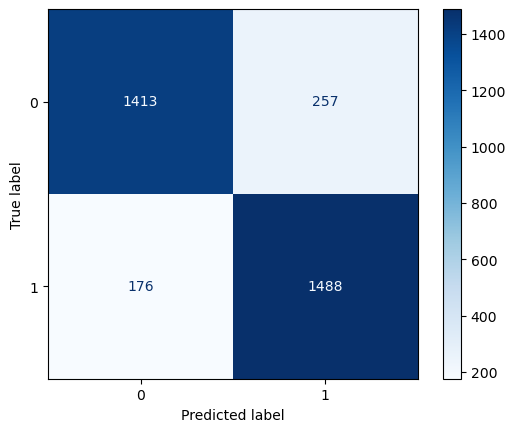

In [70]:
matriz_confusao = confusion_matrix(y_test, y_test_e)

print("Amostras: ", np.bincount(y_test_e))
print("Número de erros (treino): {}".format(np.sum(y_test != y_test_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')


tn, fp, fn, tp = matriz_confusao.ravel()
lr_fpr_test = fp / (fp + tn)
lr_tpr_test = recall_score(y_test, y_test_e)
lr_precision_test = tp/(tp+fp)
lr_recall_test = tp/(tp+fn)

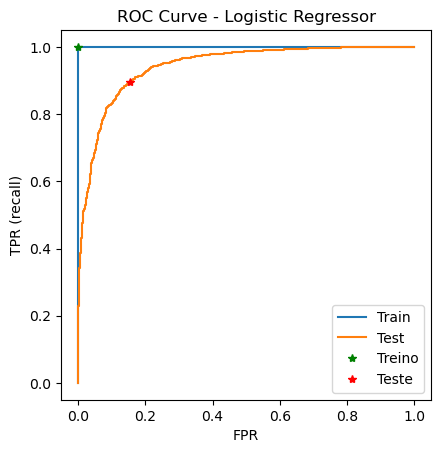

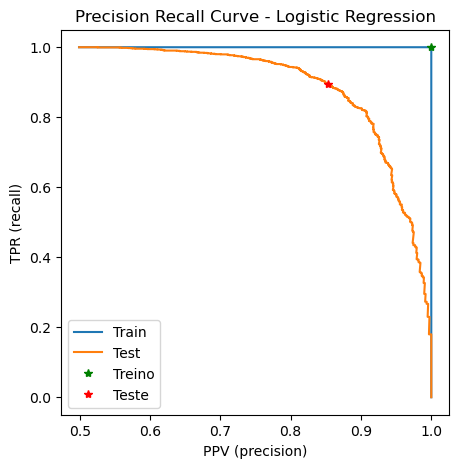

In [71]:
plt.figure()
plt.title("ROC Curve - Logistic Regressor")
plt.plot(lr_fpr_roc_train, lr_tpr_roc_train, label="Train")
plt.plot(lr_fpr_roc_test, lr_tpr_roc_test, label="Test")
plt.plot(lr_fpr_train, lr_tpr_train, '*g', label="Treino")
plt.plot(lr_fpr_test, lr_tpr_test, '*r', label="Teste")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.axis("scaled")
plt.legend()

plt.figure(figsize=(5,5))
plt.title("Precision Recall Curve - Logistic Regression")
plt.plot(lr_curve_precision_train, lr_curve_recall_train, label="Train")
plt.plot(lr_curve_precision_test, lr_curve_recall_test, label="Test")
plt.plot(lr_precision_train, lr_recall_train, '*g', label="Treino")
plt.plot(lr_precision_test, lr_recall_test, '*r', label="Teste")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()

## Support Vector Machine

In [72]:
pipe = make_pipeline(StandardScaler(with_mean=False), SVC(max_iter=10000))
param_grid = {'svc__C': [0.1, 1, 10, 100]}
# , 
#             'svc__decision_function_shape': ['ovr', 'ovo'],
#             'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#             'svc__gamma': [0.001, 0.01, 0.1, 1, 10], 
#             'svc__degree': [1, 2, 3]}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validation, y_validation)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ........................svc__C=0.1;, score=0.500 total time=  10.1s
[CV 2/3] END ........................svc__C=0.1;, score=0.501 total time=  10.2s
[CV 3/3] END ........................svc__C=0.1;, score=0.501 total time=   8.5s
[CV 1/3] END ..........................svc__C=1;, score=0.712 total time=   9.6s
[CV 2/3] END ..........................svc__C=1;, score=0.717 total time=   8.5s
[CV 3/3] END ..........................svc__C=1;, score=0.754 total time=   8.0s
[CV 1/3] END .........................svc__C=10;, score=0.790 total time=   8.0s
[CV 2/3] END .........................svc__C=10;, score=0.796 total time=   7.9s
[CV 3/3] END .........................svc__C=10;, score=0.842 total time=   8.9s
[CV 1/3] END ........................svc__C=100;, score=0.790 total time=   8.3s
[CV 2/3] END ........................svc__C=100;, score=0.796 total time=   8.3s
[CV 3/3] END ........................svc__C=100;,

In [73]:
svm = SVC(C=10) #, decision_function_shape='ovr', gamma=0.01, kernel='sigmoid')
svm.fit(corpus_trainval, y_trainval)

# Treino
y_train_e = svm.predict(corpus_trainval)
# Teste
y_test_e = svm.predict(corpus_test)

1.0
0.9424257254721327


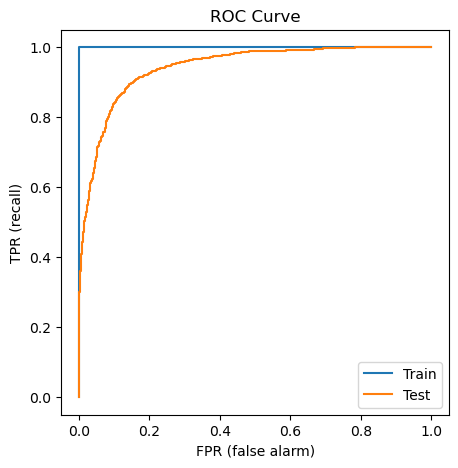

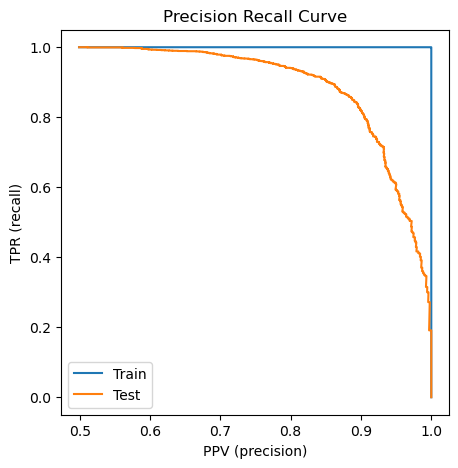

In [74]:
svm_fpr_roc_train, svm_tpr_roc_train, svm_thresholds_roc_train = roc_curve(y_trainval, svm.decision_function(corpus_trainval))
svm_fpr_roc_test, svm_tpr_roc_test, svm_thresholds_roc_test = roc_curve(y_test, svm.decision_function(corpus_test))
plt.figure(figsize=(5,5))
plt.title("ROC Curve")
plt.plot(svm_fpr_roc_train, svm_tpr_roc_train, label="Train")
plt.plot(svm_fpr_roc_test, svm_tpr_roc_test, label="Test")
plt.xlabel("FPR (false alarm)")
plt.ylabel("TPR (recall)")
plt.legend()


svm_curve_precision_train, svm_curve_recall_train, svm_thresholds_roc_train = precision_recall_curve(y_trainval, svm.decision_function(corpus_trainval))
svm_curve_precision_test, svm_curve_recall_test, svm_thresholds_roc_test = precision_recall_curve(y_test, svm.decision_function(corpus_test))
plt.figure(figsize=(5,5))
plt.title("Precision Recall Curve")
plt.plot(svm_curve_precision_train, svm_curve_recall_train, label="Train")
plt.plot(svm_curve_precision_test, svm_curve_recall_test, label="Test")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()

svm_auc_train = roc_auc_score(y_trainval, svm.decision_function(corpus_trainval))
svm_auc_test = roc_auc_score(y_test, svm.decision_function(corpus_test))

print(svm_auc_train)
print(svm_auc_test)

### Resultados Treino

Amostras:  [3340 3326]
Número de erros (treino): 0
Matriz de Confusão:


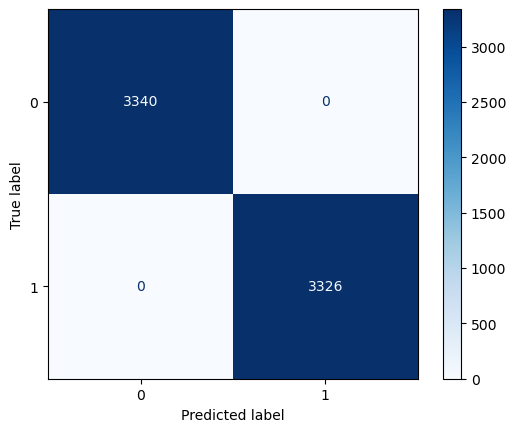

In [76]:
matriz_confusao = confusion_matrix(y_trainval, y_train_e)


print("Amostras: ", np.bincount(y_train_e))
print("Número de erros (treino): {}".format(np.sum(y_trainval != y_train_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=svm.classes_)
disp.plot(cmap='Blues')

tn, fp, fn, tp = matriz_confusao.ravel()
svm_fpr_train = fp / (fp + tn)
svm_tpr_train = recall_score(y_trainval, y_train_e)
svm_precision_train = tp/(tp+fp)
svm_recall_train = tp/(tp+fn)


### Resultados Teste

Amostras:  [1589 1745]
Número de erros (treino): 419
Matriz de Confusão:


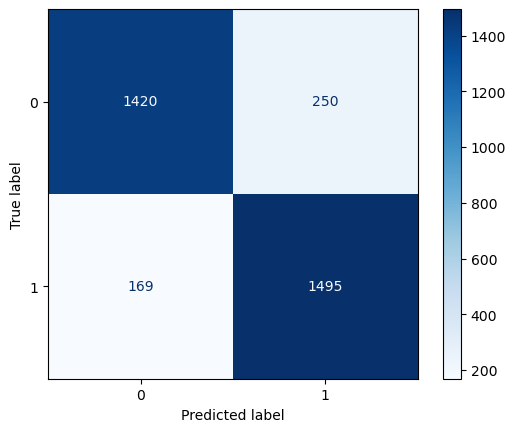

In [77]:
matriz_confusao = confusion_matrix(y_test, y_test_e)

print("Amostras: ", np.bincount(y_test_e))
print("Número de erros (treino): {}".format(np.sum(y_test != y_test_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')

tn, fp, fn, tp = matriz_confusao.ravel()
svm_fpr_test = fp / (fp + tn)
svm_tpr_test = recall_score(y_test, y_test_e)
svm_precision_test = tp/(tp+fp)
svm_recall_test = tp/(tp+fn)

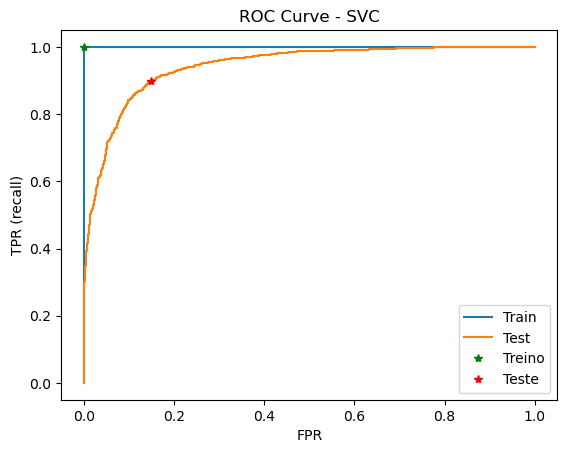

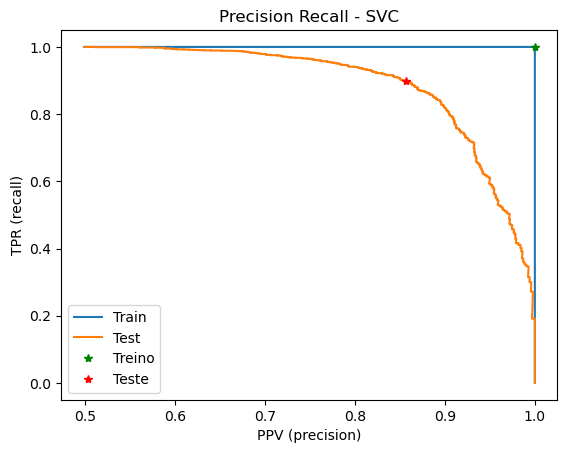

In [78]:
plt.figure()
plt.title("ROC Curve - SVC")
plt.plot(svm_fpr_roc_train, svm_tpr_roc_train, label="Train")
plt.plot(svm_fpr_roc_test, svm_tpr_roc_test, label="Test")
plt.plot(svm_fpr_train, svm_tpr_train, '*g', label="Treino")
plt.plot(svm_fpr_test, svm_tpr_test, '*r', label="Teste")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend()

plt.figure()
plt.title("Precision Recall - SVC")
plt.plot(svm_curve_precision_train, svm_curve_recall_train, label="Train")
plt.plot(svm_curve_precision_test, svm_curve_recall_test, label="Test")
plt.plot(svm_precision_train, svm_recall_train, '*g', label="Treino")
plt.plot(svm_precision_test, svm_recall_test, '*r', label="Teste")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()

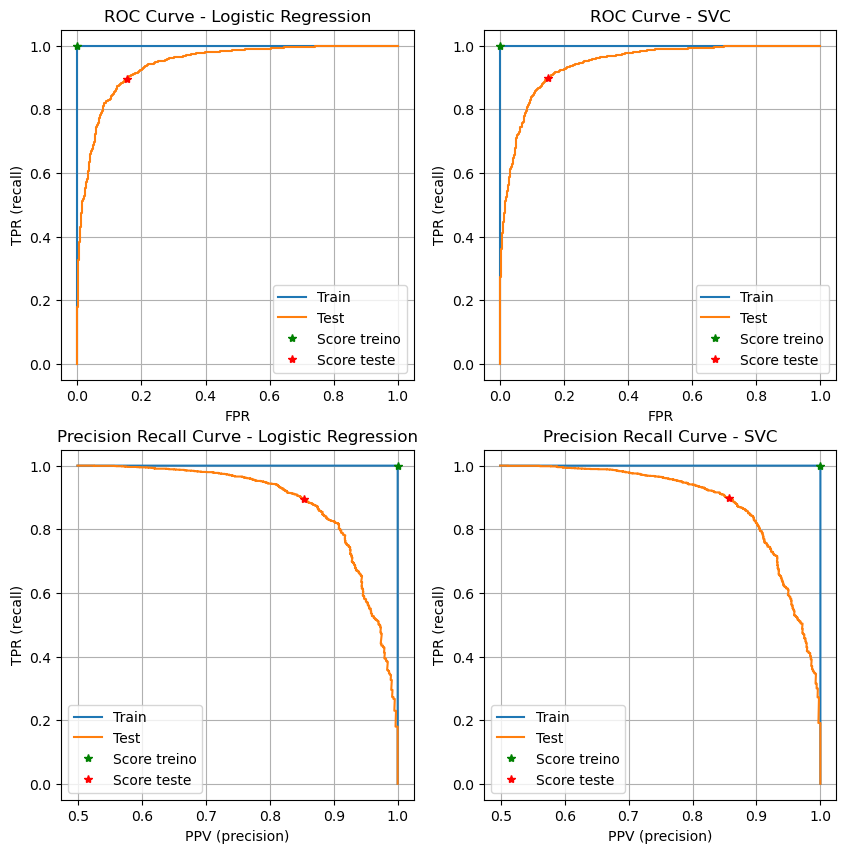

In [79]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("ROC Curve - Logistic Regression")
plt.plot(lr_fpr_roc_train, lr_tpr_roc_train, label="Train")
plt.plot(lr_fpr_roc_test, lr_tpr_roc_test, label="Test")
plt.plot(lr_fpr_train, lr_tpr_train, '*g', label="Score treino")
plt.plot(lr_fpr_test, lr_tpr_test, '*r', label="Score teste")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.title("ROC Curve - SVC")
plt.plot(svm_fpr_roc_train, svm_tpr_roc_train, label="Train")
plt.plot(svm_fpr_roc_test, svm_tpr_roc_test, label="Test")
plt.plot(svm_fpr_train, svm_tpr_train, '*g', label="Score treino")
plt.plot(svm_fpr_test, svm_tpr_test, '*r', label="Score teste")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.title("Precision Recall Curve - Logistic Regression")
plt.plot(lr_curve_precision_train, lr_curve_recall_train, label="Train")
plt.plot(lr_curve_precision_test, lr_curve_recall_test, label="Test")
plt.plot(lr_precision_train, lr_recall_train, '*g', label="Score treino")
plt.plot(lr_precision_test, lr_recall_test, '*r', label="Score teste")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.grid(True)
plt.legend()


plt.subplot(224)
plt.title("Precision Recall Curve - SVC")
plt.plot(svm_curve_precision_train, svm_curve_recall_train, label="Train")
plt.plot(svm_curve_precision_test, svm_curve_recall_test, label="Test")
plt.plot(svm_precision_train, svm_recall_train, '*g', label="Score treino")
plt.plot(svm_precision_test, svm_recall_test, '*r', label="Score teste")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.grid(True)
plt.legend()

In [80]:
print("N={}".format(max_criticas))
print("Logistic Regressor")
print("Treino:")
print("- Precision: {}".format(lr_precision_train))
print("- Recall: {}".format(lr_recall_train))
print("- False Positive Rate: {}".format(lr_fpr_train))

print("Teste:")
print("- Precision: {}".format(lr_precision_test))
print("- Recall: {}".format(lr_recall_test))
print("- False Positive Rate: {}".format(lr_fpr_test))

print("\nSVC")
print("Treino:")
print("- Precision: {}".format(svm_precision_train))
print("- Recall: {}".format(svm_recall_train))
print("- False Positive Rate: {}".format(svm_fpr_train))

print("Teste:")
print("- Precision: {}".format(svm_precision_test))
print("- Recall: {}".format(svm_recall_test))
print("- False Positive Rate: {}".format(svm_fpr_test))

N=10000
Logistic Regressor
Treino:
- Precision: 1.0
- Recall: 1.0
- False Positive Rate: 0.0
Teste:
- Precision: 0.8527220630372493
- Recall: 0.8942307692307693
- False Positive Rate: 0.15389221556886226

SVC
Treino:
- Precision: 1.0
- Recall: 1.0
- False Positive Rate: 0.0
Teste:
- Precision: 0.8567335243553008
- Recall: 0.8984375
- False Positive Rate: 0.1497005988023952
